## En este notebook se construye el modelo predictivo de Regresión Logística usando cross-validation y regularización, optimizando sobre una malla de diferentes valores del coeficiente de regularización. También se usará pipeline.


In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib as mpl 

In [17]:
import seaborn as sns 
mpl.rcParams['figure.dpi'] = 100 
df = pd.read_csv('df_clean_4.csv')

In [18]:
df.shape

(26664, 30)

In [19]:
features_response=df.columns.tolist()

In [20]:
items_to_remove = ['ID',\
'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',\
'EDUCATION_CAT',\
'graduate school', 'high school', 'none',\
'others', 'university']

In [21]:
features_response=[item for item in features_response if item  not in items_to_remove]

In [22]:
len(features_response )

19

In [23]:
features_response

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

### 1. Selección de variables

In [24]:
features = features_response[:-1]
X = df[features].values

### 2. División en conjuntos de Entrenamiento y Testeo:

In [25]:
from sklearn.model_selection import train_test_split


In [26]:
X_train, X_test, y_train, y_test = \
train_test_split(X, df['default payment next month'].values,test_size=0.2, random_state=24)

### 3. Crea objeto MinMaxScaler para normalizar los datos:

In [27]:
from sklearn.preprocessing import MinMaxScaler
min_max_sc = MinMaxScaler()

### 4. Crea modelo con regularización  L1 y máximo de iteraciones igual a 1000 para asegurar una solución aceptable:

In [28]:
from sklearn.linear_model import LogisticRegression

In [29]:
lr = LogisticRegression(solver='saga', penalty='l1',
max_iter=1000)

### 5. Importa la clase pipeline y lo crea con el escalador y el modelo de Regresion Logística:

In [30]:
from sklearn.pipeline import Pipeline
scale_lr_pipeline = Pipeline(steps=[('scaler', min_max_sc), ('model', lr)])

### 6. Muestra los parámetros por defecto del modelo:

In [31]:
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [32]:
scale_lr_pipeline.get_params()['model__C']

1.0

In [33]:
scale_lr_pipeline.set_params(model__C = 2)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

### 7. Crea un conjunto de valores del parámetro de regularización C para testear con cross-validation.

In [34]:
C_val_exponents = np.linspace(2,-3,6)
C_vals = np.float(10)**C_val_exponents

### 8. Define función a usar para llevar a cabo todo el proceso, pasando el pipeline como argumento.

In [35]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]]*len(C_vals)

    for c_val_counter in range(len(C_vals)):
        #Fija el valor de C a usar en el modelo
        pipeline.set_params(model__C = C_vals[c_val_counter])
        #cuenta los folds para cada valor de C
        fold_counter = 0
        
        for train_index, test_index in k_folds.split(X, Y):
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]

            #Fija el modelo en el conjunto de entrenamiento
            pipeline.fit(X_cv_train, y_cv_train)

            # training ROC AUC
            y_cv_train_predict_proba = pipeline.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            # testing ROC AUC
            y_cv_test_predict_proba = pipeline.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])

            #Testing ROC curves para cada fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)

            
            fold_counter += 1
        #Indica progreso
        print('Done with C = {}'.format(pipeline.get_params()['model__C']))
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
n_folds = 4
k_folds = KFold(n_splits=n_folds, shuffle=False)

### 9. Ejecuta la función cross_val_C_search_pipe.

In [39]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc =  \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline,
X_train, y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


In [43]:
np.mean(cv_test_roc_auc,axis=0)

array([0.71881693, 0.71863117, 0.71719402, 0.71534552, 0.71590355,
       0.5       ])

El mejor score es 0.71881693 y corresponde con C=100

### 10. Gráfica training y test ROC AUC v/s valores de C

Text(0.5, 1.0, 'Cross-validation on Case Study problem')

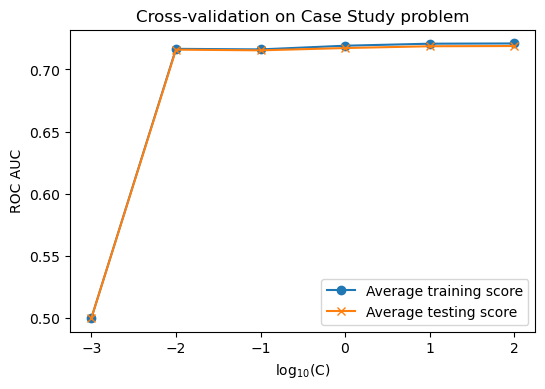

In [46]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0),
'-o', label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0),
'-x', label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross-validation on Case Study problem')

Notemos que la regularización no beneficia mucho. La mejor performance corresponde con C=100, que corresponde con una baja regularización (En realidad, el coeficiente que pondera el término de regularización es 1/100=0.01. Los scores de entrenamiento y testeo son prácticamente iguales, lo que indica que prácticamente no hay overfitting. Intentaremos hacer un poco de feature engineering mediante interacción de variables para ver si mejora la performance del modelo.

###  11. Crea interacción de features de dos en dos:

In [48]:
from sklearn.preprocessing import PolynomialFeatures
make_interactions = PolynomialFeatures(degree=2,interaction_only=True,
include_bias=False)
X_interact = make_interactions.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
X_interact, df['default payment next month'].values,
test_size=0.2, random_state=24)
print(X_train.shape)
print(X_test.shape)

                                       

(21331, 171)
(5333, 171)


Notemos que el número de features agregadas es correcto, pues deben ser 18+"18 sobre 2"=18+153=171, pues estamos haciendo interactuar las variables de dos en dos.

In [49]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search_pipe(k_folds, C_vals, scale_lr_pipeline, X_train, y_train)

C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 100.0


C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 10.0


C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\x\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


### 12. Repetimos el proceso de cross-validation y observamos la performance del modelo:

Text(0.5, 1.0, 'Cross-validation on Case Study problem')

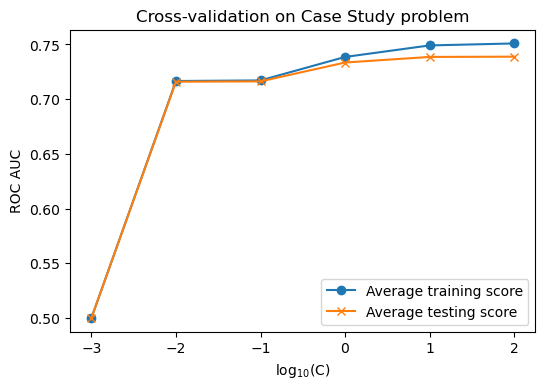

In [50]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross-validation on Case Study problem')

In [51]:
np.mean(cv_test_roc_auc, axis=0)

array([0.73879341, 0.73854812, 0.73344626, 0.71618709, 0.71590355,
       0.5       ])

Hay un mejoramiento!, El mejor score es 0.738 correspondiente con C=100.